In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.datasets import make_friedman1
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# setting global plotting settings
# roudning all floats to two digits
pd.options.display.float_format = "{:.2f}".format

set_matplotlib_formats("svg")
sns.set_context(context="notebook", font_scale=1.5)
sns.set_palette("tab10")
sns.set_style("darkgrid")
FIGSIZE = (12, 6)
RANDOM_STATE = 35

## Introduction

Let's dive into the world of partial dependence plots (PDPs), powerful visual tools that reveal the average impact a specific feature has on the predictions made by a model.

## Why Explore Partial Dependence Plots?

Visualizing how different features influence model predictions can be crucial for understanding, interpreting, and trusting the decisions made by machine learning models. PDPs help us gain insights into the relationship between the features and the predicted outcomes.

To illustrate the concept of PDPs, we will use a synthetic dataset from Scikit-learn, available [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html#sklearn.datasets.make_friedman1).

The synthetic dataset is created based on the following formula: 
$y(X) = 10\sin(\pi \cdot X_0 \cdot X_1) + 20 \cdot (X_2 - 0.5)^2 + 10 \cdot X_3 + 5 \cdot X_4 + \text{noise} \cdot N(0, 1)$. 

For our demonstration, I will generate a dataset with 7 features. However, it's important to note that only 5 of these features actually affect the output—this means the other two features do not have any predictive power. The dataset will contain 2000 samples and include a noise level set to 2.

In [4]:
# | code-fold: show

X_reg, y_reg = make_friedman1(
    n_samples=2_000, n_features=7, noise=2, random_state=RANDOM_STATE
)

# stick it into a dataframe
df_reg = pd.concat(
    [
        pd.DataFrame(
            data=X_reg, columns=["x_0", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ),
        pd.DataFrame(data=y_reg, columns=["target"]),
    ],
    axis=1,
)

# display descriptive stats
df_reg.describe().T

,count,mean,std,min,25%,50%,75%,max
x_0,2000.00,0.49,0.29,0.00,0.25,0.49,0.74,1.00
x_1,2000.00,0.50,0.29,0.00,0.25,0.51,0.76,1.00
x_2,2000.00,0.50,0.29,0.00,0.25,0.52,0.75,1.00
x_3,2000.00,0.50,0.28,0.00,0.26,0.51,0.75,1.00
x_4,2000.00,0.50,0.29,0.00,0.25,0.50,0.75,1.00
x_5,2000.00,0.50,0.29,0.00,0.24,0.49,0.75,1.00
x_6,2000.00,0.50,0.28,0.00,0.26,0.51,0.75,1.00
target,2000.00,14.48,5.26,-1.56,10.72,14.46,18.15,30.51


The dataset's input features are uniformly distributed, $U(0,1)$, which typically means their average value hovers around 0.5. In contrast, our target feature stands out with a much higher average value of approximately 14.

For our analysis, we'll be using a random forest model. It's [my go-to favorite](https://www.linkedin.com/feed/update/urn:li:activity:7169278449243607041?updateEntityUrn=urn%3Ali%3Afs_feedUpdate%3A%28V2%2Curn%3Ali%3Aactivity%3A7169278449243607041%29) for several reasons: no need for feature scaling, robustness to missing values, and its proficiency in capturing non-linear relationships. Plus, it has the added advantage of relatively quick fitting times.

In [5]:
# | code-fold: show

X = df_reg.drop(columns="target")
y = df_reg["target"]

reg = RandomForestRegressor(
    n_estimators=32,
    max_depth=9,
    min_samples_split=2,
    random_state=42,
)
_ = reg.fit(X, y)

Before examining the partial dependence of each feature on the target, let's first handle some data preparation. A practical approach is to begin with a small random sample of our data. After working through an end-to-end example using this subset, we can consider applying the same method to the larger dataset.

In [6]:
# | code-fold: show

df_sample = df_reg.sample(3, random_state=1)
df_sample

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,target
674,0.36,0.70,0.83,0.03,0.26,0.53,0.61,12.79
1699,0.32,0.70,0.38,0.02,0.38,0.40,0.14,8.29
1282,0.31,0.21,0.66,0.40,0.27,0.11,0.84,7.57


## Step-by-Step Guide to Calculating a Partial Dependence Plot (PDP)

To determine the partial dependence (PD) of a feature, such as `x_0`, on the predicted outcome, we follow a structured process:

1. **Identify the Range of the Feature**: Ascertain the range within which the feature `x_0` varies. For most datasets, this would be the minimum and maximum values that `x_0` can take.

2. **Determine the Grid Size**: Decide on a grid size, which essentially is the number of points or the sampling resolution across the feature's range.

3. **Expand the Dataset Using the Grid**: Implement the grid across the dataset. This step significantly increases the size of the dataset because for each original data point, we now have multiple points covering the entire grid.

4. **Generate Predictions**: Use the model to predict outcomes on this augmented dataset. These predictions are solely for inference, which generally has a lower computational cost.

5. **Compute the Average**: Take the mean of the predictions corresponding to each value on the grid. This average is what gives us the partial dependence value at each point.

Through this method, we can illustrate how changes in `x_0` influence the model’s predictions, regardless of the values of other features. This visual representation helps in understanding the behavior and decision-making process of complex models.

### Identify the Range of the Feature

In [7]:
# | code-fold: show
df_reg["x_0"].agg(["min", "max"])

min   0.00
max   1.00
Name: x_0, dtype: float64

When calculating the partial dependence of `x_0`, which ranges from zero to one, you have the option to consider the entire range of values `x_0` can take or focus on a specific region, such as the 90th percentile. The latter approach eliminates potential outliers that may skew the PD calculation.

### Determine the Grid Size

For this particular analysis, we're opting for a modest grid size of 7. This means we'll create a sequence of 7 points that are evenly spaced across the feature `x_0` range of 0 to 1.

### Expand the Dataset Using the Grid

Using the `np.linspace()` function in Python, we can easily generate our grid. This function creates an array of evenly spaced values over a specified interval. Once we have our grid, we can augment our dataset through a cross join operation. For those familiar with SQL, it's common knowledge that cross joins can rapidly increase the size of your data. With 3 original data points and a grid size of 7, we increase our data count to ($ 3 \times 7 = 21$ ). In this expanded dataset, the new column `x_0_sample` represents the values for `x_0` across which we want to compute the partial dependence.

In [8]:
# | code-fold: show
df_pdp = df_sample.drop(columns="x_0")
df_sample_grid = pd.Series(np.linspace(0, 1, 7), name="x_0_sample").round(2)
df_pdp = df_pdp.join(other=df_sample_grid, how="cross")
df_pdp

,x_1,x_2,x_3,x_4,x_5,x_6,target,x_0_sample
0,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.00
1,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.17
2,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.33
3,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.50
4,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.67
5,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.83
6,0.70,0.83,0.03,0.26,0.53,0.61,12.79,1.00
7,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.00
8,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.17
9,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.33


### Generate Predictions

With our expanded dataset, now consisting of 21 observations, we move forward by utilizing our model to generate predictions for each observation. In essence, we ask the original model to provide predictions for every new data point that we've added.

In [9]:
# | code-fold: show
df_pdp = df_pdp.assign(
    y_pred=reg.predict(
        df_pdp.loc[
            :, ["x_0_sample", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ].to_numpy()
    )
)
df_pdp

,x_1,x_2,x_3,x_4,x_5,x_6,target,x_0_sample,y_pred
0,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.00,5.23
1,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.17,9.61
2,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.33,12.19
3,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.50,12.58
4,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.67,12.72
5,0.70,0.83,0.03,0.26,0.53,0.61,12.79,0.83,12.66
6,0.70,0.83,0.03,0.26,0.53,0.61,12.79,1.00,12.79
7,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.00,5.76
8,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.17,9.31
9,0.70,0.38,0.02,0.38,0.40,0.14,8.29,0.33,9.89


### Compute the Average

After obtaining predictions, we aggregate results by selecting `x_0_sample` and `y_pred`, grouping by `x_0_sample`, and applying a mean aggregation function to reveal the average impact of changes in `x_0` on model predictions.

In [10]:
# | code-fold: show
df_pdp_plot = (
    df_pdp[["x_0_sample", "y_pred"]].groupby("x_0_sample", as_index=False).mean()
)
df_pdp_plot

,x_0_sample,y_pred
0,0.00,5.88
1,0.17,8.63
2,0.33,9.94
3,0.50,11.01
4,0.67,11.43
5,0.83,11.70
6,1.00,11.82


 The dataframe shows the average impact of feature `x_0` on the target variable, with an observable increase in the target variable as `x_0` values rise, as depicted below.

<!-- Keep in mind that this analysis is based on a limited dataset and coarse grid. To gain a more detailed understanding of the relationship, consider incorporating additional samples from the original dataset and refining the grid for a more nuanced visualization of the dependency between `x_0` and the target variable. Such enhancements can offer deeper insights into how the model's changes for inputs of `x_0`. -->

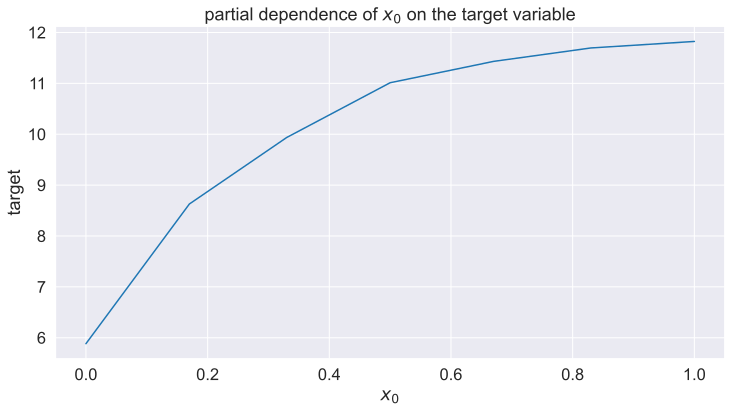

In [11]:
_, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.plot(df_pdp_plot["x_0_sample"], df_pdp_plot["y_pred"])
ax.set_xlabel("$x_0$")
ax.set_ylabel("target")
ax.set_title("partial dependence of $x_0$ on the target variable")
plt.show()

## Interpreting the Partial Dependence Plot
 The plot shows that the model responds positively to increases in `x_0`. However, this analysis is based on only three observations. To gain a more precise understanding of the relationship between `x_0` and the target variable, consider utilizing the full dataset of 2000 samples along with a finer grid of 128 points. This expansion results in $2000 * 128 = 256,000$ data points, illustrating the significant data growth when examining partial dependence for just one feature.

By using more data and a refined grid, we can generate a more accurate representation of the `x_0` variable's relationship with the target variable.

## Implementation in Code

Below is the code snippet that will generate this comprehensive dataset. Note the comments indicating where alterations are made to accommodate the full dataset and the finer grid size.

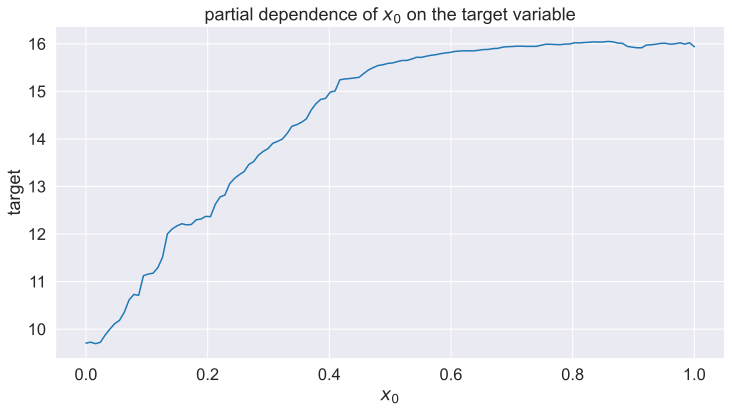

In [12]:
# | code-fold: show
df_pdp = df_reg.drop(columns="x_0")  # <- the full dataset
df_sample_grid = pd.Series(
    np.linspace(0, 1, 128),  # <- sampling is 128
    name="x_0_sample",
)
df_pdp = df_pdp.join(other=df_sample_grid, how="cross")

df_pdp = df_pdp.assign(
    y_pred=reg.predict(
        df_pdp.loc[
            :, ["x_0_sample", "x_1", "x_2", "x_3", "x_4", "x_5", "x_6"]
        ].to_numpy()
    )
)

df_pdp_plot_full = (
    df_pdp[["x_0_sample", "y_pred"]].groupby("x_0_sample", as_index=False).mean()
)

_, ax = plt.subplots(1, 1, figsize=FIGSIZE)
ax.plot(df_pdp_plot_full["x_0_sample"], df_pdp_plot_full["y_pred"])
ax.set_xlabel("$x_0$")
ax.set_ylabel("target")
ax.set_title("partial dependence of $x_0$ on the target variable")
plt.show()

After utilizing the full dataset of 256,000 samples and applying a more refined grid of 127 points, the resulting plot confirms our earlier findings that as the value of `x_0` increases, so does the target variable, and this relationship appears to be almost monotonic.

With the increased data resolution, we now have a more granular view confirming and clarifying the positive correlation between `x_0` and the target variable. This level of detail is invaluable for model interpretation and can guide decisions on feature importance and model adjustments. It underscores the capability of partial dependence plots to provide deeper insights into the model's behavior and help pinpoint how specific features drive the predictions.

### Utilizing Existing Libraries for Partial Dependence Plots

When it comes to practical applications in data science, it's often more efficient to leverage existing tools and libraries rather than creating custom code from scratch. This is particularly true for partial dependence plots (PDPs), where coding our own routine can be complex and time-consuming.

Scikit-learn, a widely-used library in the machine learning community, offers a convenient and robust implementation of partial dependence with its [partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html#sklearn.inspection.partial_dependence) function. This can save a substantial amount of effort and helps ensure that our calculations are accurate and aligned with best practices.

Additionally, for those who are already utilizing the SHAP library to compute Shapley values—which provide insight into the contribution of each feature to the prediction—there's good news. SHAP also includes functionality for generating partial dependence plots with its [shap.plots.partial_dependence](https://shap.readthedocs.io/en/latest/generated/shap.plots.partial_dependence.html) feature. This is extremely beneficial as it integrates seamlessly with other SHAP-based interpretability techniques, offering a consistent and comprehensive suite of tools for model explanation.

These existing implementations not only streamline the process but also ensure that you're taking advantage of the latest methodologies and optimizations in the field. Whether you're conducting exploratory data analysis or presenting findings to stakeholders, these tools can greatly enhance the efficiency and clarity of your model interpretation efforts.

### one-way partial dependence

The beauty of using scikit-learn's built-in functions lies in their simplicity and power. Generating partial dependence plots for your entire dataset can indeed be as straightforward as a single line of code. 
Scikit-learn takes care of the heavy lifting involved in computing the partial dependence and plotting it. This function will automatically handle the grid creation, predictions, and averaging needed to generate the PDP. The resulting plot is a powerful visual tool that can instantly convey how changes in the specified feature(s) affect the model's output, facilitating a better understanding of the model's behavior.

This ease of use, combined with the robustness of scikit-learn, makes it a go-to choice for practitioners looking to interpret their machine learning models without getting bogged down in the details of implementation. 😊

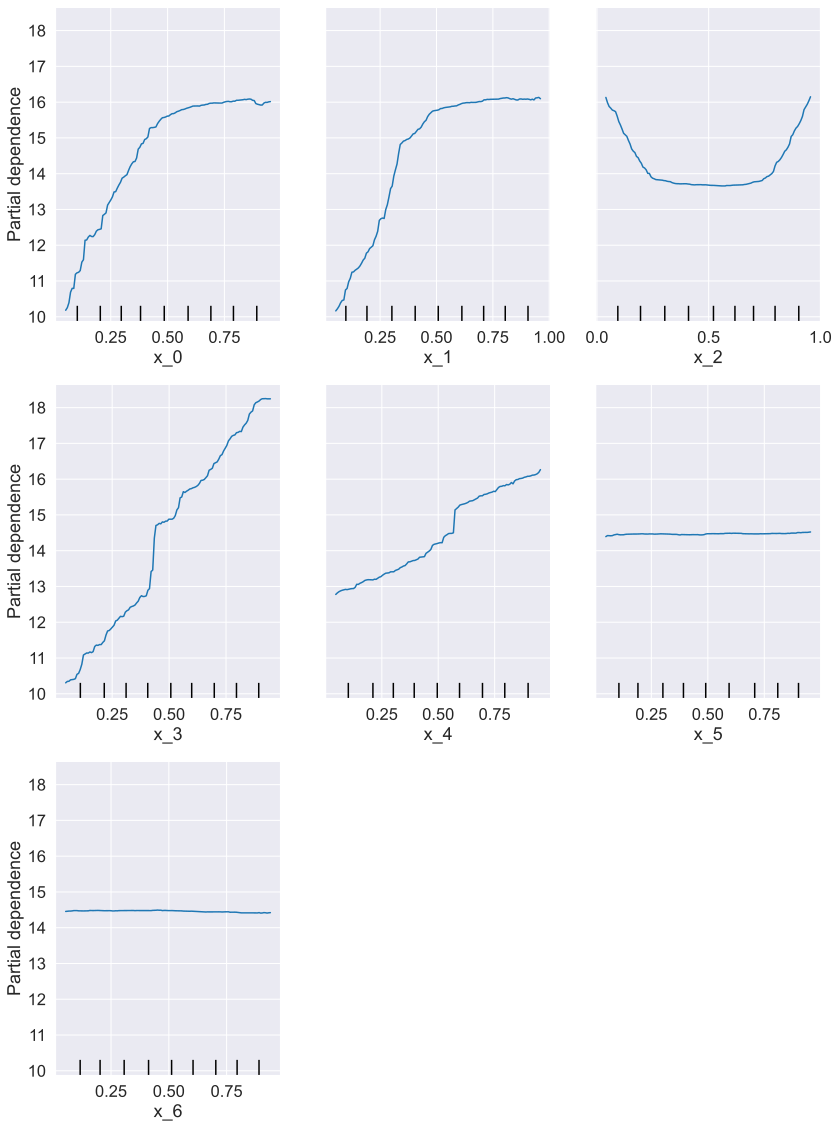

In [13]:
# | code-fold: show


_, ax = plt.subplots(1, 1, figsize=(12, 16))

PartialDependenceDisplay.from_estimator(
    estimator=reg, X=X, features=range(0, 7), grid_resolution=128, kind="average", ax=ax
)
plt.tight_layout()
plt.show()

### Insights from the Partial Dependence Plot Analysis

The partial dependence plots provide a wealth of insights into how different features impact the model's predictions. Based on the plot, we can make several observations:

- **Features `x_6` and `x_5`**: These features appear to have no meaningful impact on the model's output. Variations in `x_6` or `x_5` do not significantly alter the predicted target value. This aligns with our earlier understanding that these features represent random noise, thus confirming their lack of predictive power.

- **Feature `x_2`**: The partial dependence plot for `x_2` resembles the shape of a bathtub, indicating that the extremes of its value range lead to higher predictions for the target variable, while a mean value of 0.5 correlates with the lowest target outcome. This suggests a non-linear relationship where both low and high values of `x_2` increase the target value, with a trough in the middle.

- **Features `x_0` and `x_1`**: These features exhibit a steady monotonic increase in their impact on the target variable, which begins to plateau at higher input values. This plateau suggests that beyond a certain point, further increases in `x_0` or `x_1` have a diminished effect on the prediction.

- **Remaining Features `x_3` and `x_4`**: The plots for `x_3` and `x_4` indicate that higher values of these features generally lead to higher predicted outcomes for the target variable. Notably, there's a significant jump in the target prediction at around 0.4 for `x_3` and 0.6 for `x_4`, highlighting specific values where there might be a threshold effect or a strong non-linear influence.

These insights from the partial dependence plots can guide further data analysis and model refinement. By understanding how each feature affects the target, we can prioritize features for engineering, adjust the model to better capture non-linear relationships, and potentially simplify the model by removing non-contributory noise features.

### Exploring Feature Interactions with Two-Way Partial Dependence Plots

Partial dependence plots aren't limited to individual features; they can also be extended to explore the interactions between two features and their joint effect on the target variable. This two-dimensional analysis, known as a two-way partial dependence plot, provides a deeper understanding of how feature pairs contribute to the model's predictions. Here's how you would approach creating a two-way PDP:

1. **Select Two Features**: Choose the two features you want to analyze for interaction.

2. **Create a Sample Grid**: Construct a grid that is the Cartesian product of the individual grids for the two selected features. This means if you have 7 points for `x_0` and 7 for `x_1`, your sample grid will have 49 points representing all combinations of `x_0` and `x_1`.

3. **Expand the Dataset**: Just as with the one-way PDP, you now apply this grid to the dataset. Each original datapoint is replaced by the set of new points from the grid, dramatically increasing the dataset size.

4. **Generate Predictions**: Use the model to predict the target variable for this comprehensive grid, taking into account every combination of the two features.

5. **Compute the Average**: By averaging the predictions across the grid for each combination, you can visualize the effect of varying both features simultaneously.

The result is a contour plot or a three-dimensional surface plot that shows how changes in the two features together impact the predicted outcome. This gives insight into whether the features act independently on the target or if there are interaction effects—situations where the influence of one feature on the target depends on the value of the other feature.

Two-way partial dependence plots can help identify synergies or redundancies between features, informing decisions about feature engineering or model selection to better capture complex relationships within the data.

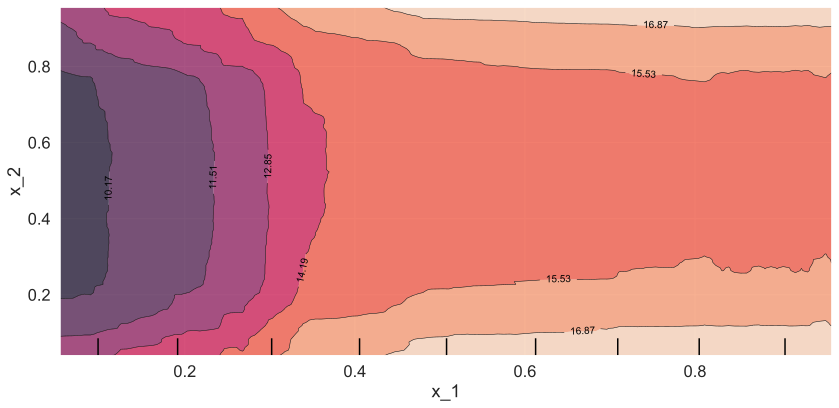

In [14]:
# | code-fold: show

_, ax = plt.subplots(1, 1, figsize=FIGSIZE)

PartialDependenceDisplay.from_estimator(
    reg, X, features=[(1, 2)], grid_resolution=128, ax=ax
)
plt.tight_layout()
plt.show()

## Bonus: Individual Conditional Expectation 🧊

Individual Conditional Expectation  (ICE) plots diverge from the average effect shown in PDPs by tracing the response of each individual observation to changes in a feature. Here's the distilled essence of ICE plots:

### Focused on the Individual

Each line in an ICE plot represents the prediction path for a single observation as the feature of interest varies. This allows us to inspect how specific instances react to feature changes individually, rather than in aggregate.

### Visual Diagnosis of Variability

ICE plots can reveal if different observations respond inconsistently to a feature change, showing increases for some and decreases for others. This can pinpoint performance issues not visible in PDPs.

### Enhanced Model Understanding

By identifying how subsets of data are influenced by feature changes, ICE plots offer detailed insights into model behavior, helping to refine predictions and address potential issues at the individual level.

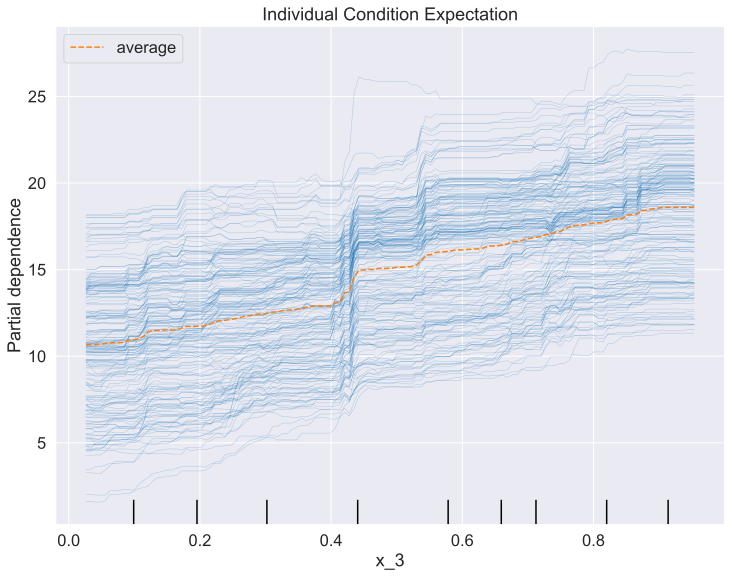

In [15]:
# | code-fold: show

_, ax = plt.subplots(1, 1, figsize=(12, 9))

idx = np.random.randint(len(X), size=int(len(X) * 0.1), dtype=int)


PartialDependenceDisplay.from_estimator(
    reg, X.loc[idx, :], features=[3], kind="both", grid_resolution=128, ax=ax
)
ax.set_title("Individual Condition Expectation")
plt.show()

In [17]:
# |echo: false
# |output: false
import gif  # noqa E402

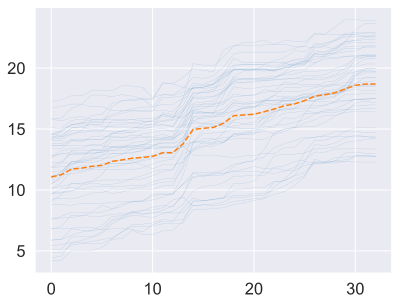

In [18]:
# |echo: false
# |output: false

idx = np.random.randint(len(X), size=int(len(X) * 0.025), dtype=int)


pdp_results = partial_dependence(
    estimator=reg,
    X=X.loc[idx, :],
    features=["x_3"],
    grid_resolution=33,
    kind="both",
)

plt.plot(
    pdp_results["individual"][0].T,
    linestyle="-",
    linewidth=0.25,
    alpha=0.33,
    color="tab:blue",
)
plt.plot(
    np.mean(pdp_results["individual"][0].T, axis=1), linestyle="--", color="tab:orange"
);

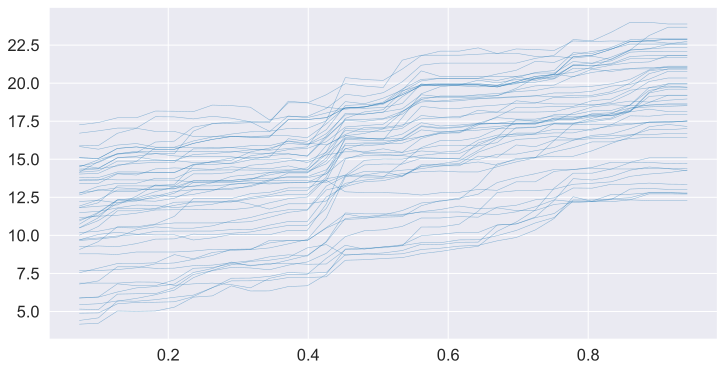

In [19]:
# |echo: false
# |output: false
individual_lines = pdp_results["individual"][0].T


_, ax = plt.subplots(1, 1, figsize=FIGSIZE)


ax.plot(
    pdp_results["grid_values"][0],
    individual_lines[:, 0],
    linestyle="-",
    linewidth=0.5,
    alpha=0.5,
    color="tab:blue",
)


xlim_begin, ylim_begin = ax.get_xlim(), ax.get_ylim()


ax.plot(
    pdp_results["grid_values"][0],
    individual_lines[:, :],
    linestyle="-",
    linewidth=0.5,
    alpha=0.5,
    color="tab:blue",
)

xlim_end, ylim_end = ax.get_xlim(), ax.get_ylim()

zoom_factor = 0
# get the global axes limits
overal_xlim = (
    min(xlim_begin[0], xlim_end[0]) * (1 - zoom_factor),
    max(xlim_begin[1], xlim_end[1]) * (1 + zoom_factor),
)
overal_ylim = (
    min(ylim_begin[0], ylim_end[0]) * (1 - zoom_factor),
    max(ylim_begin[1], ylim_end[1]) * (1 + zoom_factor),
)

In [20]:
# |echo: false
# |output: false


@gif.frame
def one_frame(i: int, overal_xlim=None, overal_ylim=None) -> None:
    _, ax = plt.subplots(1, 1, figsize=FIGSIZE)

    ax.plot(
        pdp_results["grid_values"][0],
        individual_lines[:, :i],
        linestyle="-",
        linewidth=0.75,
        alpha=0.35,
        color="tab:blue",
    )

    if i > 1:
        ax.plot(
            pdp_results["grid_values"][0],
            np.mean(individual_lines[:, :i], axis=1),
            linestyle="--",
            linewidth=3,
            color="tab:orange",
        )

    # set the overal axes
    ax.set_xlim(overal_xlim), ax.set_ylim(overal_ylim)

    # remove the ticks and lables from the axes
    xticks = ax.get_xticks()
    ax.set_xticks(xticks, labels=[])
    ax.set_xlabel("")

    yticks = ax.get_yticks()
    ax.set_yticks(yticks, labels=[])
    ax.set_ylabel("")

    plt.tight_layout()

In [21]:
# |echo: false
# |output: false

# genearate all base frames
gif_frames = [
    one_frame(i, overal_xlim, overal_ylim) for i in range(individual_lines.shape[1])
]

In [22]:
# |echo: false
# |output: false

# add bounce and freeze point
gif_frames.extend([gif_frames[-1] for _ in range(60)])
gif_frames.extend(gif_frames[::-1])

In [23]:
# |echo: false
# |output: false
gif.save(gif_frames, "artifacts/ice_lines.gif", duration=1)